In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import scipy.sparse as sps
import scipy.io as sio
import os
import sys
import math
from os.path import join

In [2]:
# sys.path.insert(0, '../..')
from ACE.ace import ACE

### loading data

In [3]:
# root_dir = '../../data/DOGMA'
data_dir = '../../data/DOGMA'

print('Reading `mtx` files...')
rna_pca = sps.csr_matrix(sio.mmread(join(data_dir, 'RNA/rna_harmonypca.mtx')))  # exported from seurat
adt_pca = sps.csr_matrix(sio.mmread(join(data_dir, 'ADT/adt_harmonypca.mtx')))  # exported from seurat
atac_lsi = sps.csr_matrix(sio.mmread(join(data_dir, 'ATAC/atac_harmonypca.mtx'))) # exported from seurat

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data = meta_data[['stim', 'predicted.celltype.l1']].copy()
meta_data.columns = ['batch', 'cell_type']

train_idx = np.where((meta_data.batch.str.lower()=='control').to_numpy())[0]
test_idx  = np.where((meta_data.batch.str.lower()=='stim').to_numpy())[0]

print('Creating `h5ad` files...')
ad_mult_rna = sc.AnnData(sps.csr_matrix(rna_pca[train_idx]), obs=meta_data.iloc[train_idx])
ad_mult_adt = sc.AnnData(sps.csr_matrix(adt_pca[train_idx]), obs=meta_data.iloc[train_idx])
ad_mult_atac = sc.AnnData(sps.csr_matrix(atac_lsi[train_idx]), obs=meta_data.iloc[train_idx])
ad_rna_test = sc.AnnData(sps.csr_matrix(rna_pca[test_idx]), obs=meta_data.iloc[test_idx])
ad_adt_test = sc.AnnData(sps.csr_matrix(adt_pca[test_idx]), obs=meta_data.iloc[test_idx])
ad_atac_test = sc.AnnData(sps.csr_matrix(atac_lsi[test_idx]), obs=meta_data.iloc[test_idx])

Reading `mtx` files...
Creating `h5ad` files...


### preprocessing

In [4]:
# already processed

### construct inputs

In [5]:
n_parts = 4
modBatch_dict = {
    'rna': [ad_mult_rna, ad_rna_test, None, None],
    'adt': [ad_mult_adt, None, ad_adt_test, None],
    'atac':[ad_mult_atac, None, None, ad_atac_test]
}

useReps_dict = {
    'rna': 'X',
    'adt': 'X',
    'atac': 'X'
}

In [6]:
np.array(list(modBatch_dict.keys()))

array(['rna', 'adt', 'atac'], dtype='<U4')

### stage1 training and inference

In [7]:
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'adt':[512, 2048], 'atac':[1024, 512]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'adt':[0.2, 0.2],  'atac':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir='../../outputs/case2_DOGMA',
    n_latent1=40, n_latent2=256, seed=1234, 
    num_workers=0  # have to set 0 in jupyter notebook, otherwise reporting: https://github.com/jupyter/nbconvert/issues/1066
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'adt', 'atac']
batch1: ['rna']
batch2: ['adt']
batch3: ['atac']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=4.7460, temp=10.0000, batch0 loss=4.7460, 
Epoch 19, loss=4.6503, temp=10.0000, batch0 loss=4.6503, 
Epoch 29, loss=4.5876, temp=10.0000, batch0 loss=4.5876, 
Epoch 39, loss=4.5218, temp=10.0000, batch0 loss=4.5218, 
Epoch 49, loss=4.4670, temp=10.0000, batch0 loss=4.4670, 
Epoch 59, loss=4.4227, temp=10.0000, batch0 loss=4.4227, 
Epoch 69, loss=4.3744, temp=10.0000, batch0 loss=4.3744, 
Epoch 79, loss=4.3330, temp=10.0000, batch0 loss=4.3330, 
Epoch 89, loss=4.2797, temp=10.0000, batch0 loss=4.2797, 
Epoch 99, loss=4.2629, temp=10.0000, batch0 loss=4.2629, 


In [8]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['rna'], ['adt'], ['atac']]
)
ad_integ

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 26041 × 40
    obs: 'batch', 'cell_type', 'raw_batch', 'domain'

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


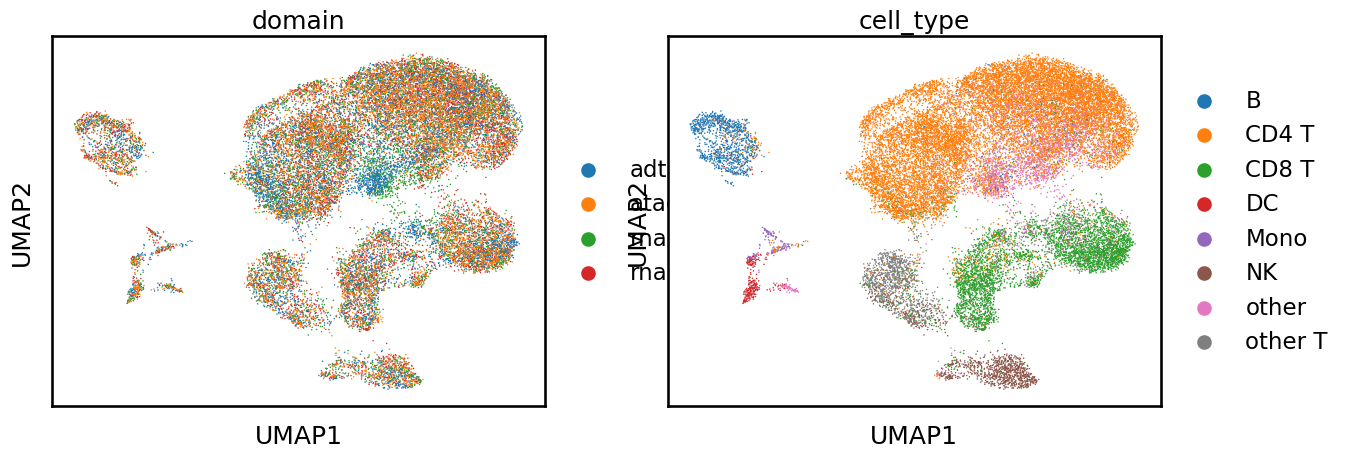

In [17]:
sc.pp.neighbors(ad_integ, n_neighbors=15, use_rep='X')
sc.tl.umap(ad_integ)

sc.pl.umap(ad_integ, color=['domain', 'cell_type'])

### stage2 training and inference

In [10]:
model.stage2_fit(
    batch_size=512,
    epochs=10,
    lr=1.75e-4, 
    log_step=5, 
    obvious_be=True
)

Training stage2
Epoch 0, rna-loss=0.0564, adt-loss=0.0678, atac-loss=0.0554, 
Epoch 4, rna-loss=0.0311, adt-loss=0.0305, atac-loss=0.0306, 
Epoch 9, rna-loss=0.0303, adt-loss=0.0293, atac-loss=0.0300, 


In [11]:
ad_integ2 = model.stage2_infer(
    modBatch_dict, useReps_dict, output_key1='stage1_emb', output_key2='stage2_emb', 
    knn=2, mod_weights={'rna':1/3, 'adt':1/3, 'atac':1/3}
)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


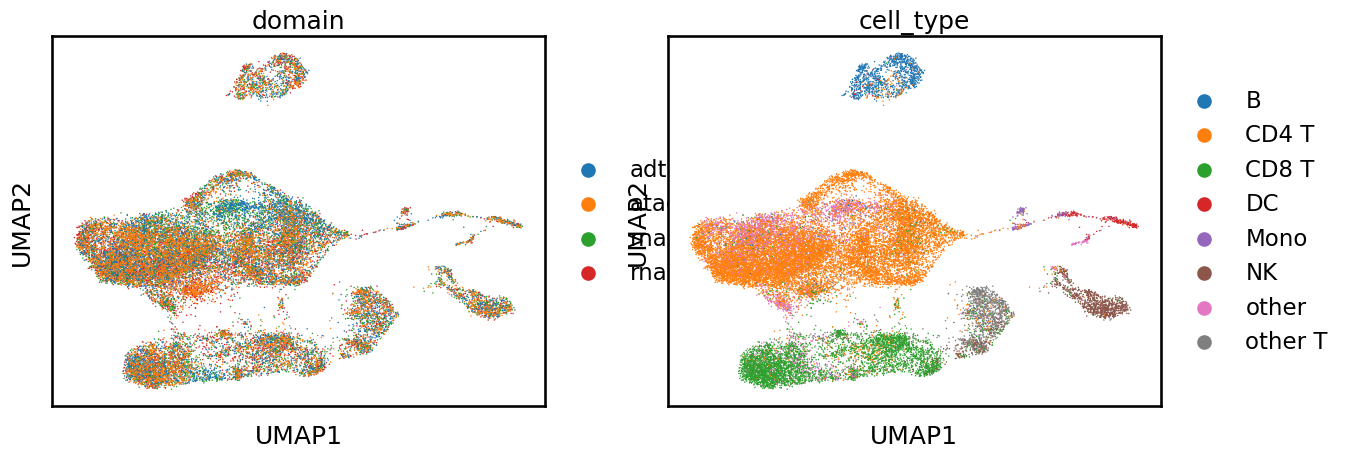

In [18]:
sc.pp.neighbors(ad_integ2, n_neighbors=15, use_rep='X')
sc.tl.umap(ad_integ2)

sc.pl.umap(ad_integ2, color=['domain', 'cell_type'])

## evaluation

In [13]:
from ACE.evaluation import eval_clustering, eval_lisi, eval_bridge, eval_bridge_above2

#### nmi, ari

In [14]:
ad_integ.obsm['stage1_emb'] = ad_integ.X.copy()
ad_integ2.obsm['final_emb'] = ad_integ2.X.copy()

nmi1, ari1 = eval_clustering(
    ad_integ, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='stage1_emb',
    use='nmi', nmi_method='arithmetic')

nmi2, ari2 = eval_clustering(
    ad_integ2, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='final_emb',
    use='nmi', nmi_method='arithmetic')

print('stage 1: nmi={:.4f}, ari={:.4f}'.format(nmi1, ari1))
print('stage 2: nmi={:.4f}, ari={:.4f}'.format(nmi2, ari2))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


stage 1: nmi=0.6192, ari=0.6920
stage 2: nmi=0.6203, ari=0.6893


#### domain(modal)-lisi, batch-lisi

In [15]:
df_lisi1 = eval_lisi(
        ad_integ,
        batch_keys=['domain'],
        use_rep='stage1_emb', use_neighbors=False,
    )

df_lisi2 = eval_lisi(
        ad_integ2,
        batch_keys=['domain'],
        use_rep='final_emb', use_neighbors=False,
    )

print('stage 1: domain(batch)-lisi={:.4f}'.format(df_lisi1.domain_LISI[0]))
print('stage 2: domain(batch)-lisi={:.4f}'.format(df_lisi2.domain_LISI[0]))

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


stage 1: domain(batch)-lisi=0.6671
stage 2: domain(batch)-lisi=0.7259


#### modality alignment scores

In [16]:
modBatch_dict['rna'][1].uns['domain'] = 'rna'
modBatch_dict['adt'][2].uns['domain'] = 'adt'
modBatch_dict['atac'][3].uns['domain'] = 'atac'

bridge_res = eval_bridge_above2(
        [modBatch_dict['rna'][1], modBatch_dict['adt'][2], modBatch_dict['atac'][3]],
        label_key='cell_type',
        batch_key='batch',
        mod_key='domain',
        use_rep='stage1_emb',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM: rna-adt=0.04126
FOSCTTM: rna-atac=0.03105
FOSCTTM: adt-atac=0.06635
FOSCTTM=0.04622
Matching score: rna-adt=0.03706
Matching score: rna-atac=0.13041
Matching score: adt-atac=0.03078
Match_score=0.06608
